In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import multiprocessing as mp
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth
from sklearn.mixture import GaussianMixture

from IPython.display import display, Latex

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

### Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



#### Python tip. Web request and smarter file reading

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
values = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
values.shape

(15, 8416)

In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [5]:
data = dict(zip(names, values))

# Code

## 1) Exploring the dataset

### Functions for data-analysis and plotting

In [6]:
# A function to compute the KDE by using an automatically-estimated bandwidth
def KDE_Sklearn(data, x_dense, kernel="epanechnikov"):
    bandwidth = estimate_bandwidth(data, n_jobs=int(mp.cpu_count()/2))
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde_skl.fit(data)
    log_pdf = kde_skl.score_samples(x_dense) # Sklearn returns log(density)

    return np.exp(log_pdf), bandwidth


# A function to fit 1D data with a gaussian mixture
def GaussMix_sklearn(data, x_dense, n_components, weights_init, means_init):
    model = GaussianMixture(n_components=n_components, weights_init=weights_init, means_init=means_init, 
                            init_params='k-means++', tol=1e-5, n_init=100)
    results = model.fit(data)
    pdf = np.exp(results.score_samples(x_dense))
    components = results.predict_proba(x_dense)
    weights = results.weights_
    means = results.means_.flatten()
    stds = np.sqrt(results.covariances_.flatten())
    
    return pdf, components, weights, means, stds


# A function to plot the KDE of 1D data, and also:
# 1) fit the data with a gaussian mixture and plot the results, if requested;
# 2) compare the data with the respective uncertainties, if the latter are present.
def Plot1D(data, data_err=None, x_label='', y_label='', x_min=None, x_max=None, 
           GaussMix_n_components=None, weights_init=None, means_init=None):
    if x_min==None: x_min = np.min(data)
    if x_max==None: x_max = np.max(data)
    
    if data_err is None:
        plt.rcParams['figure.figsize'] = [8 , 8]
        fig, axes = plt.subplots(1, 1)
        ax = axes
    else:  
        plt.rcParams['figure.figsize'] = [16 , 8]
        fig, axes = plt.subplots(1, 2)
        ax = axes[0]

    x_dense = np.linspace(x_min, x_max, 1000)
    KDE, bandwidth = KDE_Sklearn(data[:, np.newaxis], x_dense[:, np.newaxis], kernel="epanechnikov") 
    ax.plot(x_dense, KDE, color='red', label=f'KDE (bandwidth={bandwidth:.3f})') 
    
    ax.set_xlabel(x_label)
    ax.set_ylabel('pdf')
    ax.set_xlim(0.99*x_min, 1.01*x_max)
    ax.set_ylim(top=1.1*np.max(KDE))
    
    # Executed only if the gaussian-mixture fit is requested
    if GaussMix_n_components is not None:
        pdf, components, weights, means, stds = GaussMix_sklearn(data[:,np.newaxis], x_dense[:,np.newaxis], 
                                                                 GaussMix_n_components, weights_init, means_init)
        ax.plot(x_dense, pdf, color='black', ls='--', label=f'{int(GaussMix_n_components)} Gaussians mixture fit')
        for i in range(GaussMix_n_components):
            # To check if the components are correct
            #from scipy.stats import norm
            #ax.plot(x_dense, weights[i]*norm.pdf(x_dense, means[i], stds[i]), color='orange', alpha=0.5)
            ax.plot(x_dense, pdf*components[:,i], ls=':', alpha=0.7, 
                    label=f'$\\mu_{i+1} = {means[i]:.2f}$, $\\sigma_{i+1} = {stds[i]:.2f}$, $weight_{i+1} = {weights[i]:.2f}$')
        ax.set_ylim(top=1.5*np.max(KDE))
            
    ax.legend(loc='upper left', fontsize=13)

    # Executed only if the uncertainties on the data are passed to the function
    if data_err is not None:
        ax = axes[1]
        ax.scatter(data, data_err, s=15, color='gray', edgecolor='black', linewidth=0.5, alpha=0.5)
        ax.plot([x_min, x_max], [x_min, x_max], color='red', ls='--')
        ax.set_ylim(0.99*x_min, 1.01*x_max)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
    
    return fig, axes

In [7]:
# A function to visually search for relations between two variables by plotting a scatter-plot and a color-map.
def Plot2D(x_data, y_data, x_label='', y_label='', nbins=100, x_min=None, x_max=None, y_min=None, y_max=None, xlog=False, ylog=False):
    plt.rcParams['figure.figsize'] = [16 , 8]
    fig, axes = plt.subplots(1, 2)

    if x_min==None: x_min = np.min(x_data)
    if x_max==None: x_max = np.max(x_data)
    if y_min==None: y_min = np.min(y_data)
    if y_max==None: y_max = np.max(y_data)


    ax = axes[0]
    ax.scatter(x_data, y_data, s=15, color='gray', edgecolor='black', linewidth=0.5, alpha=0.5)  
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if xlog==True: 
        ax.set_xscale('log')
        ax.set_xlim(0.5*x_min, 1.5*x_max)
    else: 
        ax.set_xlim(0.99*x_min, 1.01*x_max)
    
    if ylog==True: 
        ax.set_yscale('log')
        ax.set_ylim(0.5*y_min, 1.5*y_max)
    else:
        ax.set_ylim(0.95*y_min, 1.05*y_max)


    ax = axes[1]
    if xlog==True: 
        binx = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=nbins)
        ax.set_xscale('log')
        ax.set_xlim(0.5*x_min, 1.5*x_max)
    else: 
        binx = np.linspace(start=x_min, stop=x_max, num=nbins)
        ax.set_xlim(0.99*x_min, 1.01*x_max)
        
    if ylog==True: 
        biny = np.logspace(start=np.log10(y_min), stop=np.log10(y_max), num=nbins)
        ax.set_yscale('log')
        ax.set_ylim(0.5*y_min, 1.5*y_max)
    else:
        biny = np.linspace(start=y_min, stop=y_max, num=nbins)
        ax.set_ylim(0.95*y_min, 1.05*y_max)
    
    if (xlog==True or ylog==True): 
        hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)  
    else:
        hist = ax.hist2d(x_data, y_data, bins=(binx, biny), cmap=plt.cm.jet)
        
    cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
    fig.colorbar(hist[3], cax=cax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    return fig, axes

### 1.1) Right ascension

ra = *Right ascension in J2000 coordinates. If the GRB was observed by multiple instruments, the localisation with the smallest angular uncertainty is used.*

pos_error = *1σ error on the localisation. A 2d Gaussian pdf is assumed, implying that the probability that the true position of the GRB lies within 1σ degrees is ~39.3%.*

ra = [113.629 257.21  201.02  ... 201.3   193.475 270.675]


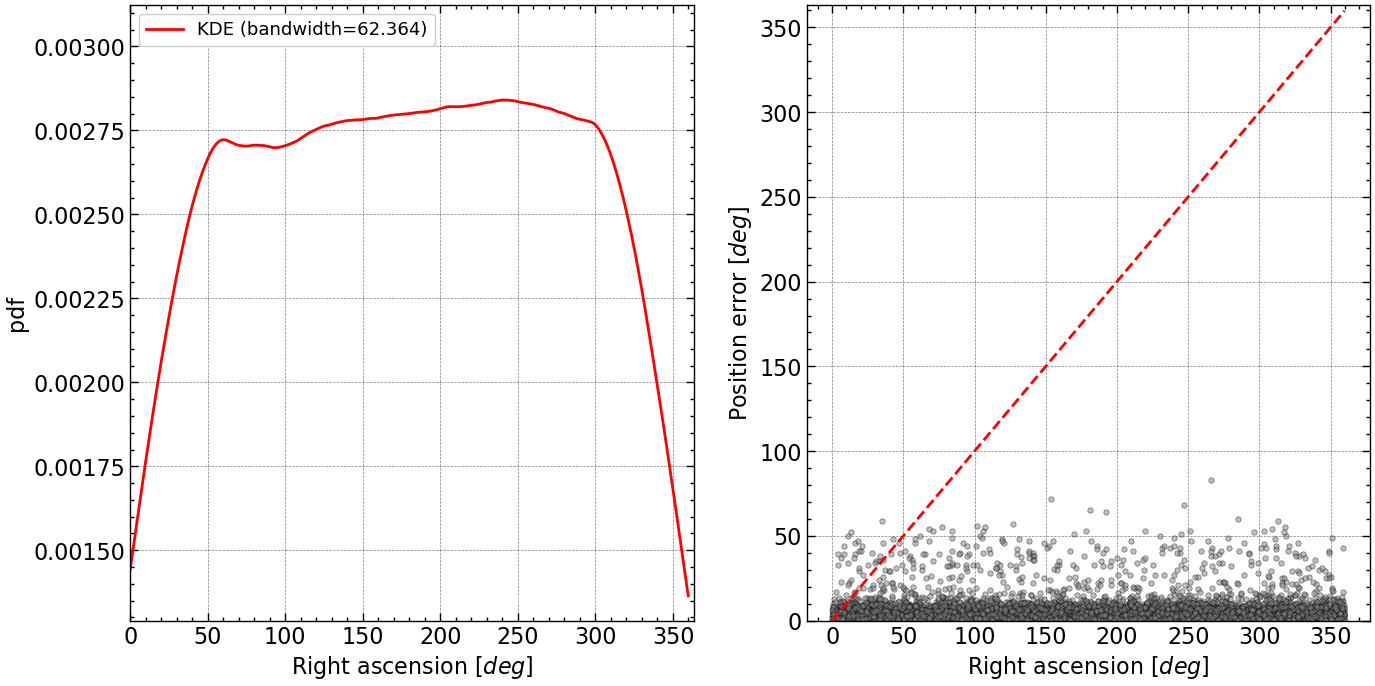

In [8]:
ra = np.array(data['ra'], dtype=float)
pos_error = np.array(data['pos_error'], dtype=float)
print(f'ra = {ra}')
fig, axes = Plot1D(ra, pos_error, 
                   x_label='Right ascension $[deg]$', y_label='Position error $[deg]$')

### 1.2) Declination

decl = *Declination in J2000 coordinates. If the GRB was observed by multiple instruments, the localisation with the smallest angular uncertainty is used.*

decl = [ 16.7244  26.54     1.54   ... -45.4167  -8.3833  24.7667]


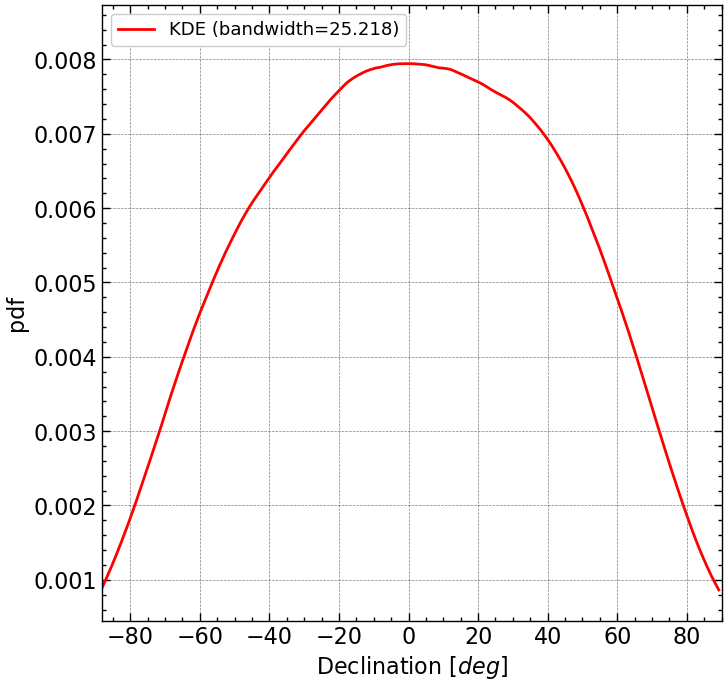

In [9]:
decl = np.array(data['decl'], dtype=float)
print(f'decl = {decl}')
fig, axes = Plot1D(decl, x_label='Declination $[deg]$')

### 1.3) T90

T90 = *Duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%. This parameter depends on the efficiency with which photons of various energies can be observed, making the T90 dependent on the detector.*

T90_error = *Estimated 1σ error on the duration of the T90 interval.*

In [10]:
T90 = np.array(data['T90'], dtype=float)
mask_T90 = T90 > 0
T90_err = np.array(data['T90_error'], dtype=float)
print(f'Discarded {np.sum(~mask_T90)} points over {len(T90)}.')
print(f'T90 = {T90[mask_T90]}')
print(f'T90_err = {T90_err[mask_T90]}')

Discarded 1059 points over 8416.
T90 = [ 91.906  14.592   2.048 ...   3.136 208.576   5.184]
T90_err = [8.307 0.724 0.905 ... 0.59  1.118 0.181]


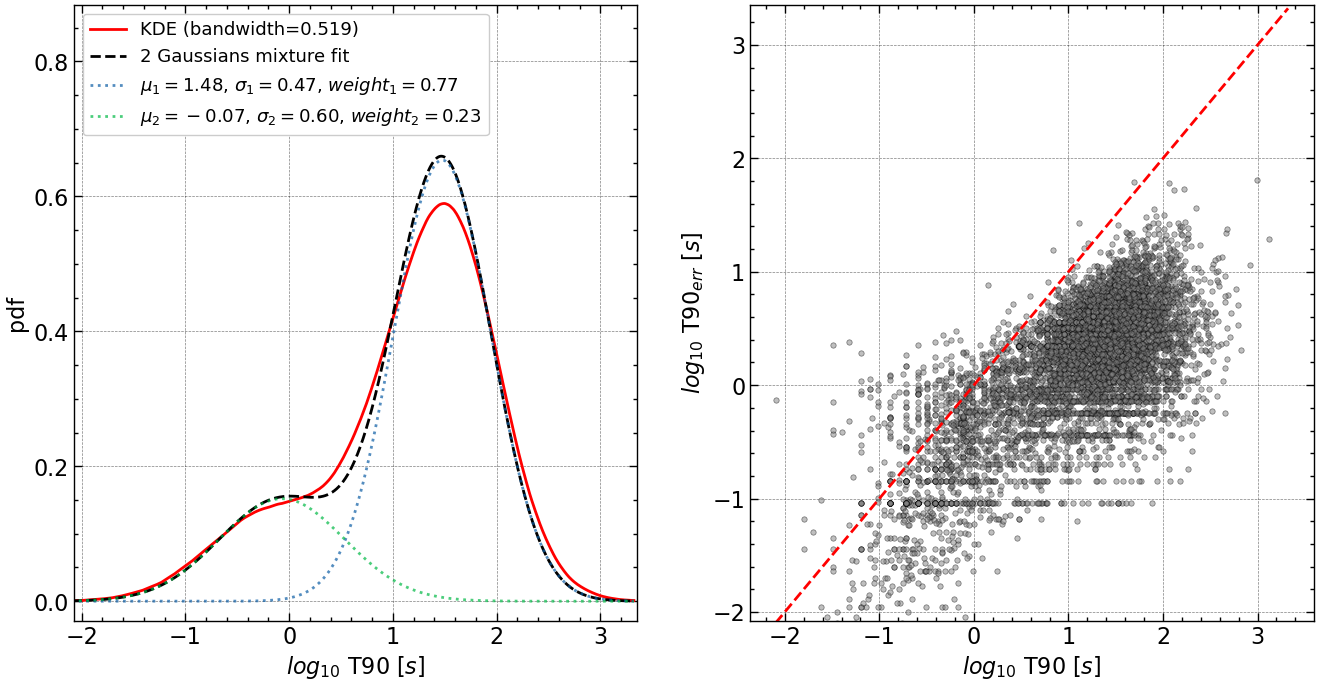

In [11]:
temp = T90_err[mask_T90].copy()
temp[temp>0] = np.log10(temp[temp>0])
fig, axes = Plot1D(np.log10(T90[mask_T90]), temp, 
                   x_label='$log_{10}$ T90 $[s]$', y_label='$log_{10}$ T90$_{err}$ $[s]$',
                   GaussMix_n_components=2)

This looks like a superposition of two gaussians ($\mu \approx 30.20s$ and $\mu \approx 0.87s$), even though the fit is not perfect.\
The difference in the weights may be due to the fact that long-GRBs are easier to observe compared to short-GRBs.

The signals above $\approx 10^{0.6} s \approx 4s$ have relative uncertainties smaller than unity, while this is not always true for the signals below such threshold.

### 1.4) Fluence

fluence = *The time integrated total energy per unit surface. Please note that the observed value strongly depends on the energy band and thus the detector that observed the burst.
For the Fermi-GBM detector, the energy band is 10-1000 keV.
For the Swift (BAT) detector, the energy band is 15-150 keV.
For the BeppoSAX detector, the energy band is 40-700 keV.
For the BATSE detector, the energy band is 20-300 keV.*

fluence_err = *Estimated 1σ error on the fluence.*

In [12]:
fluence = np.array(data['fluence'], dtype=float)
mask_fluence = fluence > 0
fluence_err = np.array(data['fluence_error'], dtype=float)
print(f'Discarded {np.sum(~mask_fluence)} points over {len(fluence)}.')
print(f'fluence = {fluence[mask_fluence]}')
print(f'fluence_err = {fluence_err[mask_fluence]}')

Discarded 986 points over 8416.
fluence = [7.9751e-06 7.0660e-06 5.7502e-07 ... 2.4858e-08 1.6510e-07 2.6055e-06]
fluence_err = [9.7398e-08 3.1584e-08 1.2548e-08 ... 1.0496e-08 1.7015e-08 1.8857e-08]


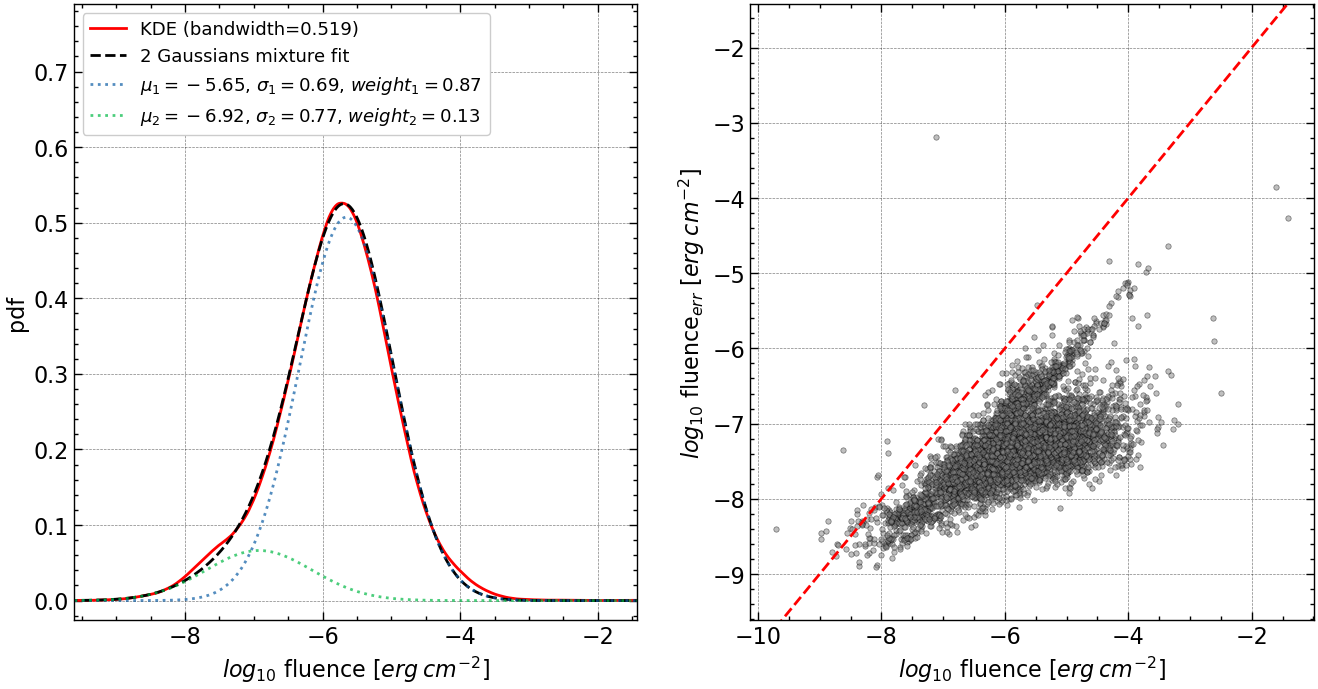

In [13]:
temp = fluence_err[mask_fluence].copy()
temp[temp>0] = np.log10(temp[temp>0])
fig, axes = Plot1D(np.log10(fluence[mask_fluence]), temp, 
                   x_label='$log_{10}$ fluence $[erg \: cm^{-2}]$', y_label='$log_{10}$ fluence$_{err}$ $[erg \: cm^{-2}]$',
                   GaussMix_n_components=2, means_init=[[-5.7], [-7.2]])

This also looks like a superposition of two gaussians ($\mu \approx 2.24 \times 10^{-6} erg \: cm^{-2}$ and $\mu \approx 1.20 \times 10^{-7} erg \: cm^{-2}$), even though the difference in the weights is even larger than in the previous fit.

The relative uncertainties are always smaller than unity.

### 1.5) Redshift

redshift = *Distance to the GRB.*

In [14]:
redshift = np.array(data['redshift'], dtype=float)
mask_redshift = redshift > 0
print(f'Discarded {np.sum(~mask_redshift)} points over {len(redshift)}.')

Discarded 7807 points over 8416.


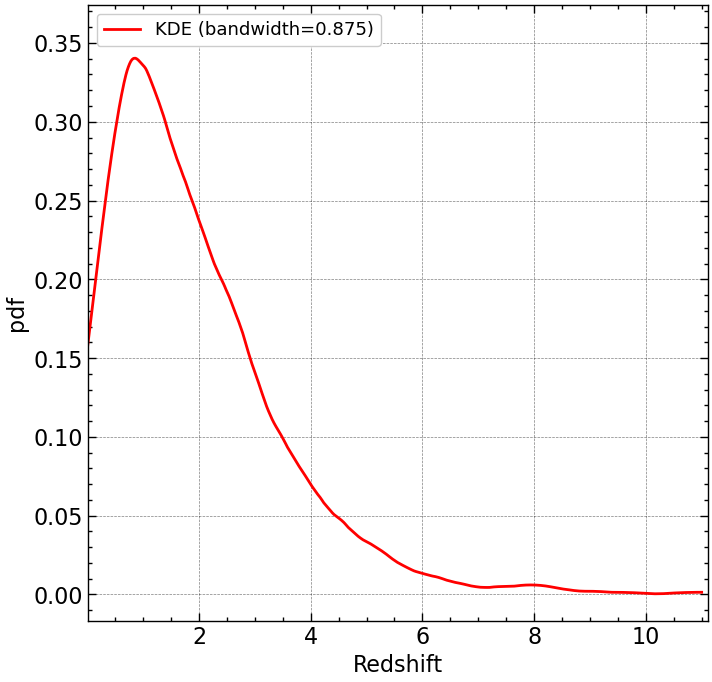

In [15]:
fig, axes = Plot1D(redshift[mask_redshift], x_label='Redshift')

## 2) Seaching for relations

### 2.1) ra VS decl

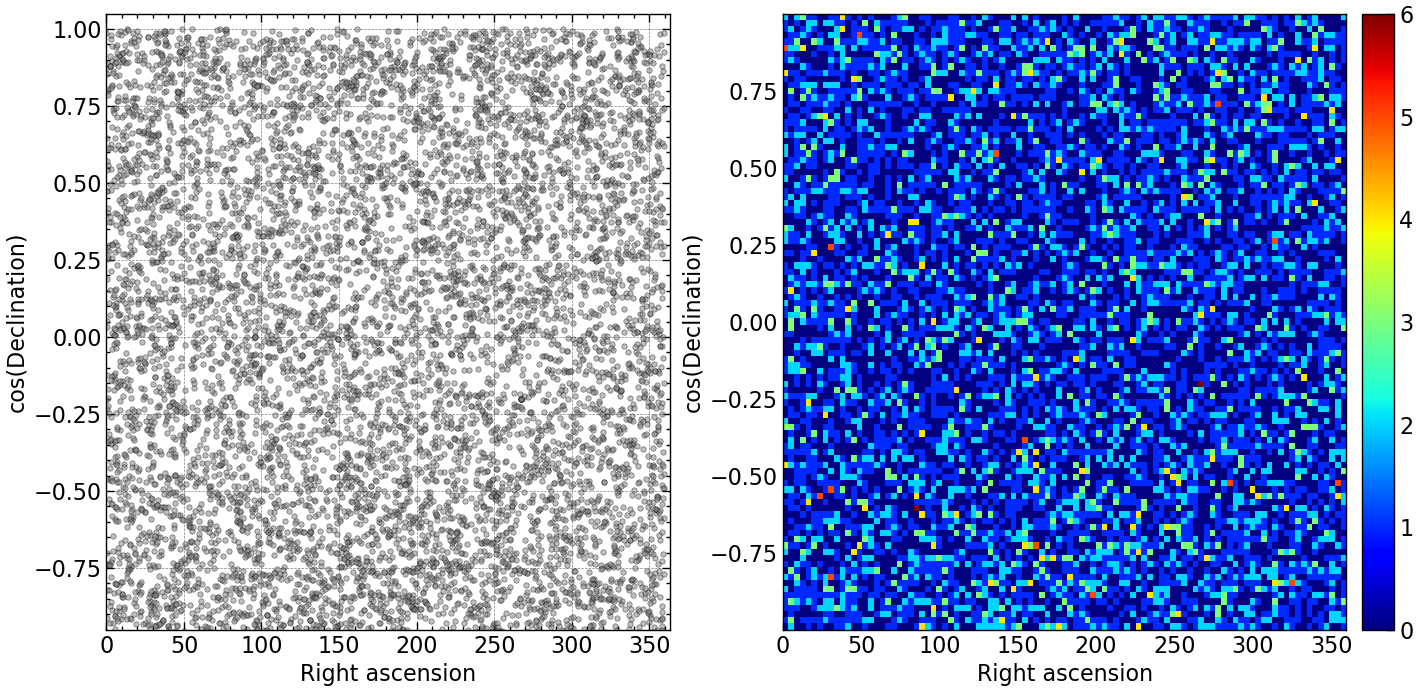

In [16]:
fig, axes = Plot2D(ra, np.cos(np.pi/2+np.deg2rad(decl)), x_label='Right ascension', y_label='cos(Declination)')

The distribution appears uniform in celestial coordinates.

### 2.2) T90 VS fluence

Discarded 1177 points over 8416.


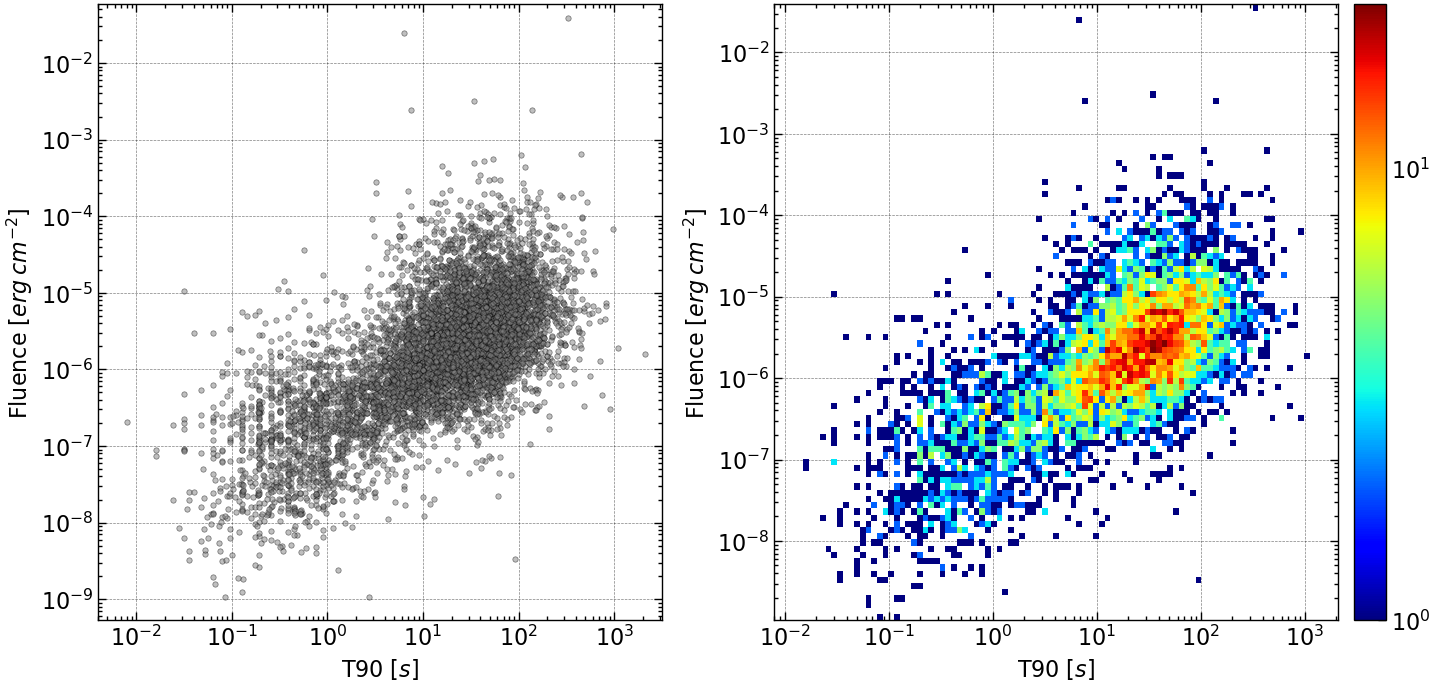

In [17]:
mask = np.array(mask_T90 & mask_fluence)
print(f'Discarded {np.sum(~mask)} points over {len(T90)}.')

fig, axes = Plot2D(T90[mask], fluence[mask], x_label='T90 $[s]$', y_label='Fluence $[erg \: cm^{-2}]$', xlog=True, ylog=True)

It appears that two clusters are present: one at high time-durations and high fluences and the other, less populated, at low time-durations and low fluences.\
It makes sense, since if the GRB last longer, then the time-integral of the flux will be bigger (if the fluxes of long-GRBs and short-GRBs are comparable, of course).

### 2.3) redshift VS T90

Discarded 7849 points over 8416.


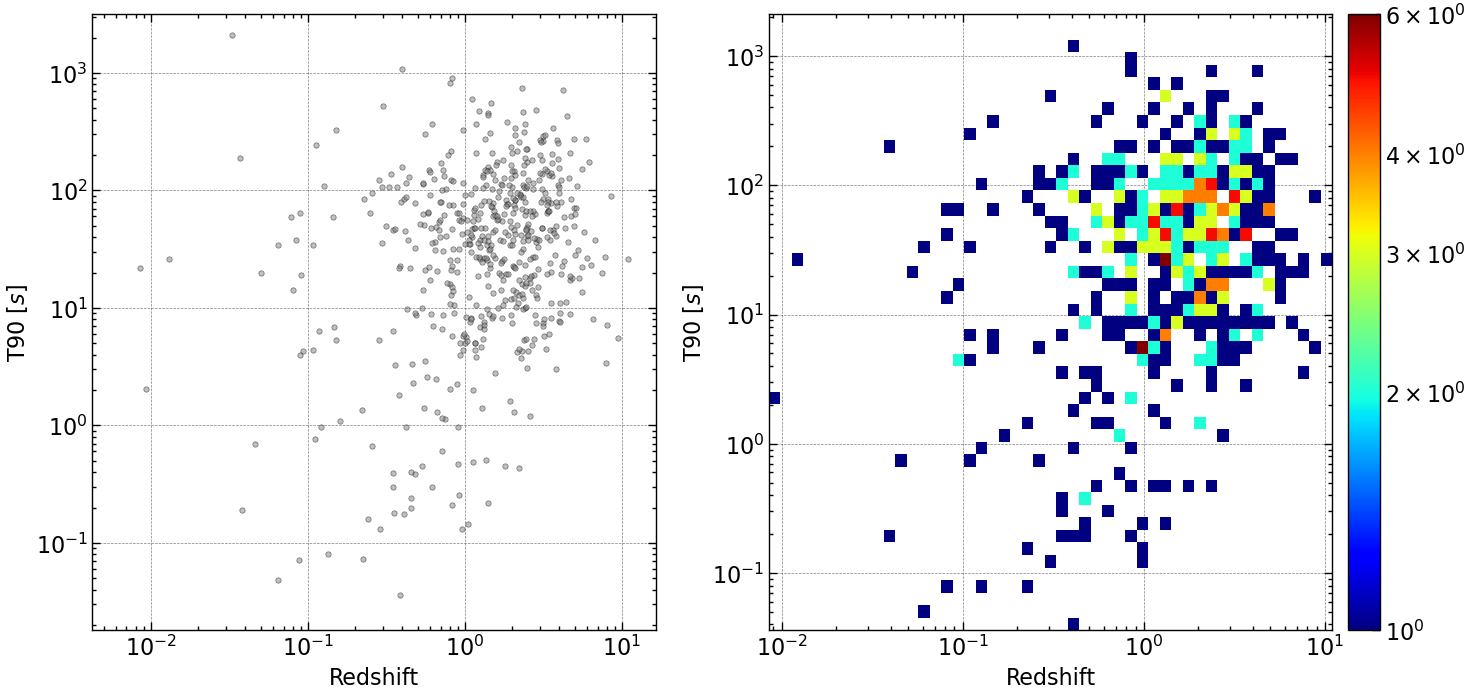

In [18]:
mask = np.array(mask_T90 & mask_redshift)
print(f'Discarded {np.sum(~mask)} points over {len(T90)}.')


fig, axes = Plot2D(redshift[mask], T90[mask], x_label='Redshift', y_label='T90 $[s]$', xlog=True, ylog=True, nbins=50)

From the very few points we have, it appears that long-GRBs are farther away than short-GRBs.

### 2.4) redshift VS fluence

Discarded 7838 points over 8416.


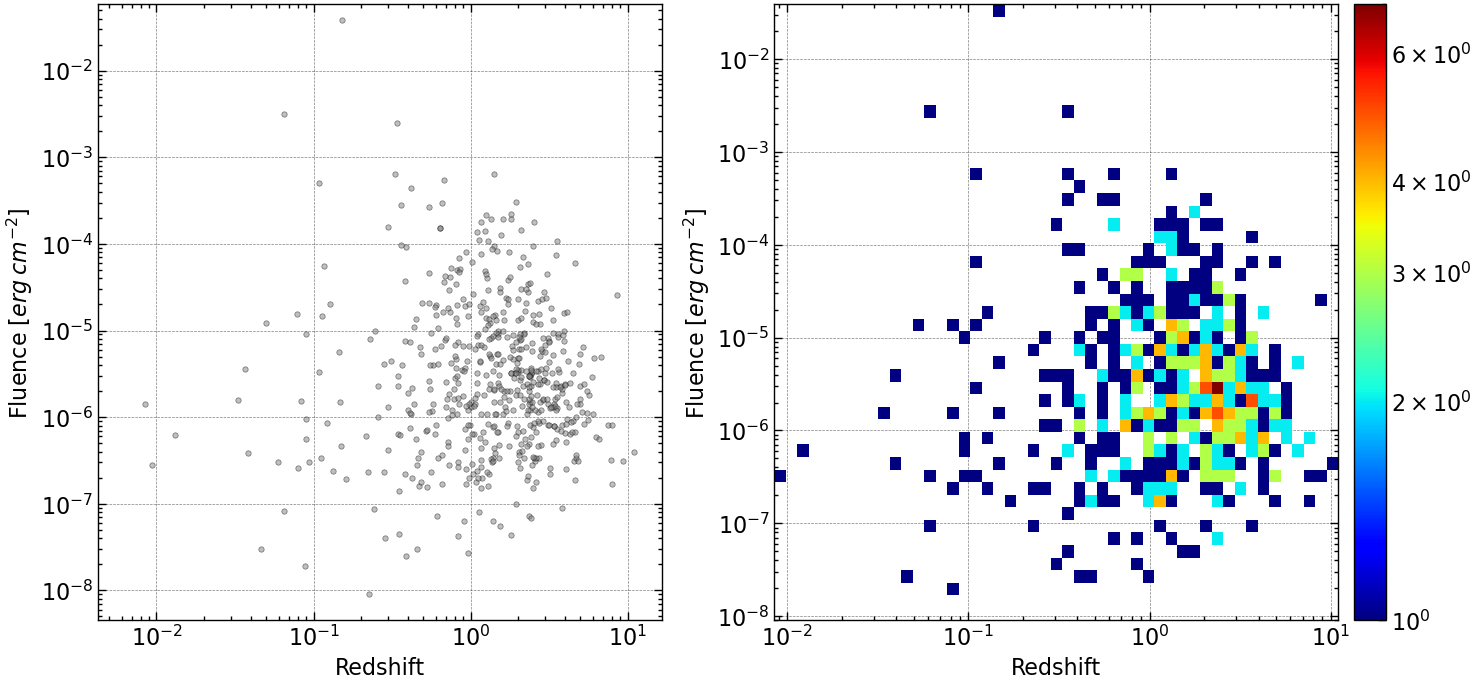

In [19]:
mask = np.array(mask_fluence & mask_redshift)
print(f'Discarded {np.sum(~mask)} points over {len(T90)}.')


fig, axes = Plot2D(redshift[mask], fluence[mask], x_label='Redshift', y_label='Fluence $[erg \: cm^{-2}]$', xlog=True, ylog=True, nbins=50)

Again, from the very few points we have, it appears that long-GRBs display a higher fluence than short-GRBs.

## 3) Clustering: T90 VS fluence

### 3.1) `KMeans`

[KMeans Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [20]:
def PlotClusters(X, labels):
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique[labels_unique >= 0])
    print(f'labels = {labels_unique}')
    print("number of estimated clusters :", n_clusters)
    
    fig = plt.figure(figsize=(8,8))
    plt.scatter(X[labels==-1,0], X[labels==-1,1], color='gray', alpha=0.5)
    for i in range(n_clusters):
        plt.scatter(X[labels==i,0], X[labels==i,1], alpha=0.5)
        
    plt.xlabel('T90 $[s]$')
    plt.ylabel('Fluence $[erg \: cm^{-2}]$');
    
    return fig

(7239, 2)
labels = [0 1]
number of estimated clusters : 2


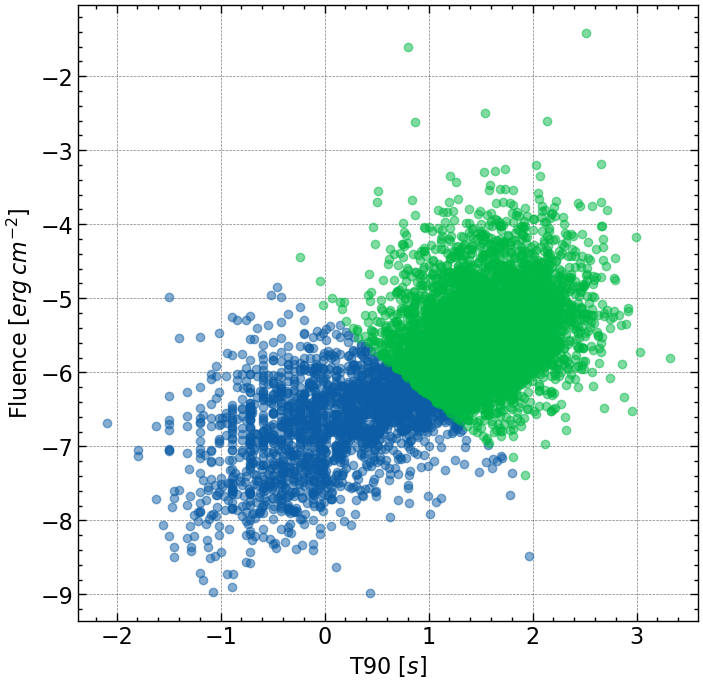

In [21]:
from sklearn.cluster import KMeans

mask = np.array(mask_T90 & mask_fluence)
X = np.array([np.log10(T90[mask]), np.log10(fluence[mask])]).T
print(X.shape)

n_clusters = 2
clf = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, tol=1e-9, verbose=False)
clf.fit(X)
labels = clf.predict(X)     

fig = PlotClusters(X, labels)

The clustering provided by `KMeans` confirms that we can distinguish between a population of long-lasting GRBs with high fluence and another population of short-lasting GRBs with low fluence. 

However, in this case the number of clusters is an hyperparameter of the model that we have arbitrarily set equal to two.

In [26]:
# Cross validation
from sklearn.model_selection import GridSearchCV

cross_val_kmeans = False

if cross_val_kmeans:
    n_clusters_range = np.arange(1, 6) # Test the number of clusters from 1 to 5
    print(n_clusters_range)

    K = 5 # Do 5-fold cross validation
    grid = GridSearchCV(KMeans(init='k-means++', n_init=100, tol=1e-9), {'n_clusters': n_clusters_range}, cv= K) # Try each number of clusters with K-folds
    grid.fit(X)

    h_opt = grid.best_params_['n_clusters']
    print(h_opt)

[1 2 3 4 5]
5


<font color='red'>I tried to implement cross-validation to estimate the optimal number of clusters, but it always returns the biggest value (even if the `n_clusters_range` array is reversed).\
 Morever, I have no idea of which loss-function it is trying to minimize.</font>

### 3.2) `MeanShift`

[MeanShift Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

[estimate_bandwidth Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html)

Search for the optimal bandwidth for the KDE

In [23]:
from sklearn.cluster import MeanShift
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

bandwidth = estimate_bandwidth(X, n_jobs=int(mp.cpu_count()/2))
print(f'Optimal bandwidth = {bandwidth:.2f}')

Optimal bandwidth = 0.92


Fit the data

labels = [-1  0  1  2  3]
number of estimated clusters : 4


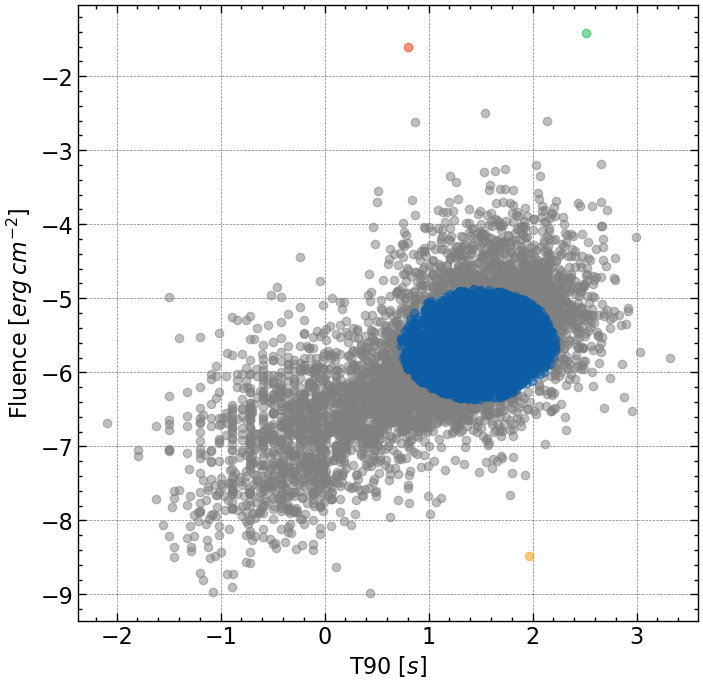

In [24]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, n_jobs=int(mp.cpu_count()/2))
ms.fit(scaler.fit_transform(X))
labels = ms.labels_

fig = PlotClusters(X, labels)

By using the optimal bandwidth and setting `cluster_all=False`, it appears that `MeanShift` is only able to identify the major cluster.

Let's try to manually change the bandwidth and to set `cluster_all=True`.

`cluster_all` = *If true, then all points are clustered, even those orphans that are not within any kernel. Orphans are assigned to the nearest kernel. If false, then orphans are given cluster label -1.*

labels = [0 1 2 3 4 5 6 7 8 9]
number of estimated clusters : 10


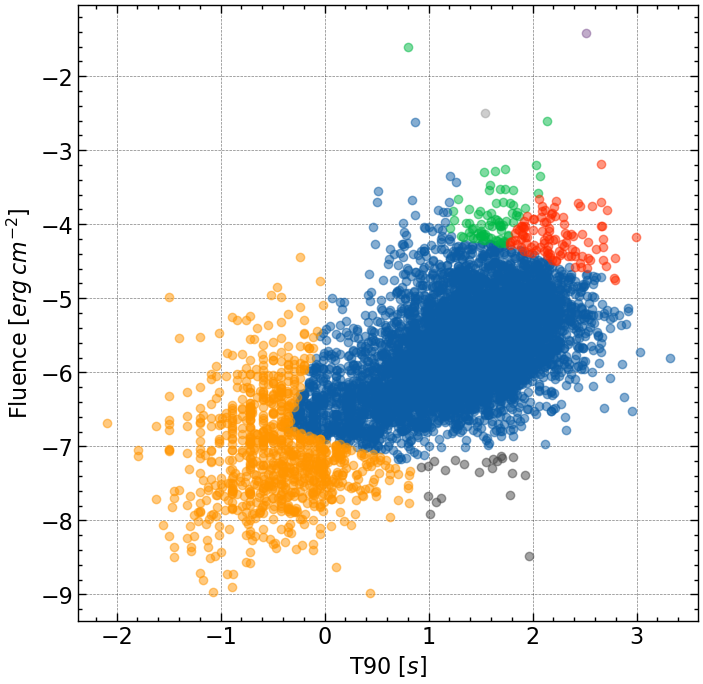

In [25]:
bandwidth = 0.53
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, n_jobs=int(mp.cpu_count()/2))
ms.fit(scaler.fit_transform(X))
labels = ms.labels_

fig = PlotClusters(X, labels)

<font color='red'>I was not able to implement a cross-validation pipe in this case, because `MeanShift` does not provide a score.</font>